# Analysis of AQP4 staining
Using the 1D line plot approach


## Tidy data

In [109]:
import pandas as pd
import seaborn as sns

In [110]:
def split(delimiters, string, maxsplit=0):
    import re
    regexPattern = '|'.join(map(re.escape, delimiters))
    return re.split(regexPattern, str(string), maxsplit)

def isolate_variables (index):
    delimiters = "_"
    variables = ['f', 'm', 'ZT6', 'ZT18', 'TPer2KO', 'Per2flfl', 'DorCX', 'Thal', 'Hippo', 'SCN']
    names = ['sex', 'genotype', 'timepoint', 'region']
    result = []
    for x in split(delimiters, index) :
        if x in variables:
            result.append(''.join(filter(str.isalnum, x)))
    return ','.join(b for a,b in zip(names, result))

In [111]:
df = pd.read_excel("data/Merged_no_bins.xlsx", index_col=0)
df.set_index("dist", inplace=True)

df = df.T

df["variables"] = df.index.map(isolate_variables)
df = pd.concat([df, df['variables'].str.split(",", expand=True)], axis=1)
df.rename(columns={0:"sex", 1:"genotype", 2:"timepoint", 3:"region"}, inplace=True)
df.drop(columns=["variables"], inplace=True)
df = df.reset_index().rename(columns={"index":"name"})
df_wide = df
df = df.melt(id_vars=["name", "sex", "genotype", "timepoint", "region"], value_name="intensity", var_name="distance")
df[["distance"]] = df[["distance"]].apply(pd.to_numeric)

df.to_csv("data.csv")
df.dtypes

name          object
sex           object
genotype      object
timepoint     object
region        object
distance     float64
intensity    float64
dtype: object

## Number of vessels

In [112]:
df_counts = df[df["distance"] == df["distance"].abs().min()]
print("Total number of vessels:")
print(df_counts["name"].unique().size)
print()
print(df_counts.groupby(["region", "sex"]).count()["name"])
print()
print(df_counts.groupby(["timepoint", "genotype"]).count()["name"])

Total number of vessels:
213

region  sex
DorCX   f      50
        m      57
Hippo   f      50
        m      56
Name: name, dtype: int64

timepoint  genotype
ZT18       Per2flfl    59
           TPer2KO     39
ZT6        Per2flfl    62
           TPer2KO     53
Name: name, dtype: int64


## Line plots

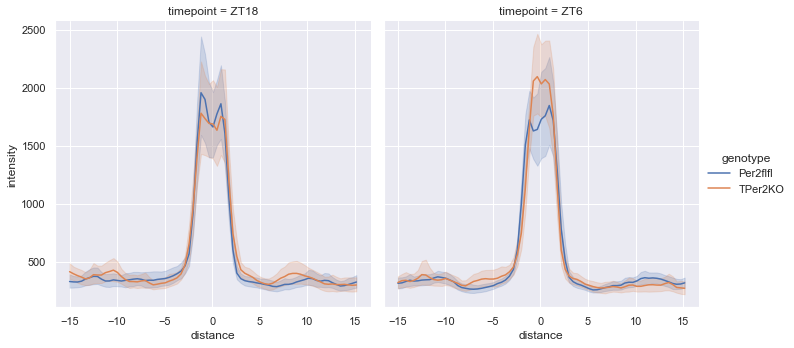

In [113]:
sns.set_theme()
sns.relplot(data=df,
            x="distance",
            y="intensity",
            hue="genotype",
            col="timepoint",
            kind="line")

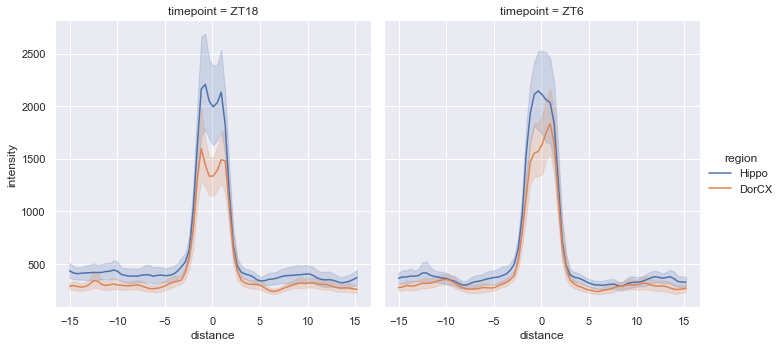

In [114]:
sns.relplot(data=df,
            x="distance",
            y="intensity",
            hue="region",
            col="timepoint",
            kind="line")

## Standardisation

In [115]:
# Need to reload the dataframe if you run this cell more than once
df = df_wide.melt(id_vars=["name", "sex", "genotype", "timepoint", "region"], value_name="intensity", var_name="distance")

signal = df[df["distance"].between(-2.5, 2.5)].index
background = df.index.difference(signal)
print("Sanity check:")
print(df.loc[signal]["distance"].unique())
print(df.loc[background]["distance"].unique())

signal_mean = df.loc[signal].groupby("name")["intensity"].mean()
background_mean = df.loc[background].groupby("name")["intensity"].mean()

df = df.merge(signal_mean, how="left", on="name", suffixes=("", "_signal_mean"))
df = df.merge(background_mean, how="left", on="name", suffixes=("", "_background_mean"))

Sanity check:
[-2.43 -2.011 -1.592 -1.173 -0.754 -0.335 0.084 0.503 0.922 1.341 1.76
 2.179]
[-15.0 -14.581 -14.162 -13.743 -13.324 -12.905 -12.486 -12.067 -11.648
 -11.229 -10.81 -10.391 -9.972 -9.553 -9.134 -8.715 -8.296 -7.877 -7.458
 -7.039 -6.62 -6.201 -5.782 -5.363 -4.944 -4.525 -4.106 -3.687 -3.268
 -2.849 2.598 3.017 3.436 3.855 4.274 4.693 5.112 5.531 5.95 6.369 6.788
 7.207 7.626 8.045 8.464 8.883 9.302 9.721 10.14 10.559 10.978 11.397
 11.816 12.235 12.654 13.073 13.492 13.911 14.33 14.749 15.168]


### I am not sure if this is how you want to do the standard score calculation:

In [116]:
df["standard_score"] = (df["intensity"] - df["intensity_background_mean"]) / (df["intensity"].std())
df

,name,sex,genotype,timepoint,region,distance,intensity,intensity_signal_mean,intensity_background_mean,standard_score
0,('20_m_Per2flfl_ZT18_S2_62873745081d9_hrm_Hipp...,m,Per2flfl,ZT18,Hippo,-15.0,392.427,838.176667,228.506869,0.246869
1,('20_m_Per2flfl_ZT18_S2_62873745081d9_hrm_Hipp...,m,Per2flfl,ZT18,Hippo,-15.0,499.738,671.039333,244.200443,0.384848
2,('20_m_Per2flfl_ZT18_S2_62873745081d9_hrm_Hipp...,m,Per2flfl,ZT18,Hippo,-15.0,139.935,713.668833,259.272902,-0.179727
3,('20_m_Per2flfl_ZT18_S2_62873745081d9_hrm_Hipp...,m,Per2flfl,ZT18,Hippo,-15.0,170.937,750.998750,286.995164,-0.174787
4,('20_m_Per2flfl_ZT18_S2_62873745081d9_hrm_Hipp...,m,Per2flfl,ZT18,Hippo,-15.0,523.528,1222.624917,365.430180,0.238101
...,...,...,...,...,...,...,...,...,...,...
15544,('24_m_TPer2KO_ZT18_S5_628737454a309_hrm_Hippo...,m,TPer2KO,ZT18,Hippo,15.168,232.302,1177.963667,392.577082,-0.241380
15545,('24_m_TPer2KO_ZT18_S5_628737454a309_hrm_Hippo...,m,TPer2KO,ZT18,Hippo,15.168,336.365,964.282667,435.061836,-0.148641
15546,('24_m_TPer2KO_ZT18_S5_628737454a309_hrm_Hippo...,m,TPer2KO,ZT18,Hippo,15.168,806.474,1409.442417,664.876623,0.213250
15547,('24_m_TPer2KO_ZT18_S5_628737454a309_hrm_Hippo...,m,TPer2KO,ZT18,Hippo,15.168,341.514,1771.792083,522.516721,-0.272596


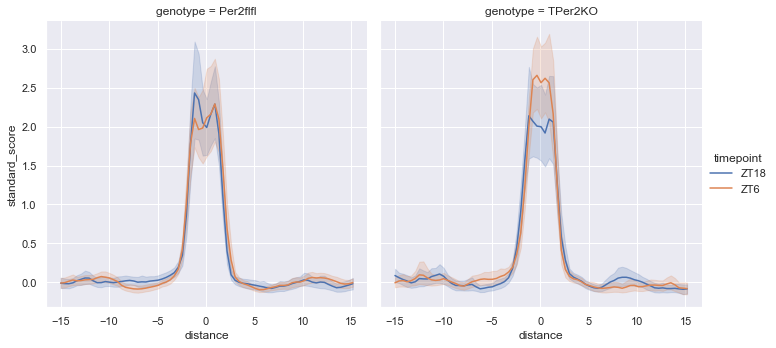

In [117]:
sns.relplot(data=df,
            x="distance",
            y="standard_score",
            hue="timepoint",
            col="genotype",
            kind="line")